In [144]:
%%capture
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
import statnlpbook.util as util
import statnlpbook.mt as mt
util.execute_notebook('word_mt.ipynb')

<!---
Latex Macros
-->
$$
\newcommand{\Xs}{\mathcal{X}}
\newcommand{\Ys}{\mathcal{Y}}
\newcommand{\y}{\mathbf{y}}
\newcommand{\balpha}{\boldsymbol{\alpha}}
\newcommand{\bbeta}{\boldsymbol{\beta}}
\newcommand{\aligns}{\mathbf{a}}
\newcommand{\align}{a}
\newcommand{\source}{\mathbf{s}}
\newcommand{\target}{\mathbf{t}}
\newcommand{\ssource}{s}
\newcommand{\starget}{t}
\newcommand{\repr}{\mathbf{f}}
\newcommand{\repry}{\mathbf{g}}
\newcommand{\x}{\mathbf{x}}
\newcommand{\prob}{p}
\newcommand{\a}{\alpha}
\newcommand{\b}{\beta}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\DeclareMathOperator{\argmin}{argmin}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
\newcommand{\length}[1]{\text{length}(#1) }
\newcommand{\indi}{\mathbb{I}}
$$

# (Word-based) Machine Translation

##  Machine Translation (MT)

* Paradigms: 
  * Rule-based vs **statistical**
  * **feature-engineering** vs neural
  * **word** vs phrase vs syntax units 

##  Word Based MT

Translate **word-by-word**
* **foundational** to all current approaches (e.g. neural methods)
* **subcomponent** in more complex systems (for alignments)

## MT as Structured Prediction

* **source** sentence \\(\source\\)
    * aka $\x$, usually tokenized 
* **target** sentence \\(\target\\)
    * aka $\y$, usually tokenized 
* a **model** \\(s_\params(\target,\source)\\) to measure match of \\(\target\\) to $\source$

### Training
learn the parameters \\(\params\\) from data 
* usually from **parallel corpora** of **aligned source and target sentences**
* Where can you get such data from?

### Translation
predict highest-scoring translation given source $\source$:

\begin{equation}
\argmax_\target s_\params(\target,\source)
\end{equation}

MT approaches differ primarily in 
* how \\(s\\) is defined, 
* how \\(\params\\) are learned
* how the \\(\argmax\\) is found

### Modelling
How to define $s_\params(\target,\source)$?

## Generative Models 
How is the $(\target,\source)$ data **generated**? 

Think about the problem **backwards**
* Generate the target using $\prob_{\params_t}(\target)$
* Generate the source $\source$ using $\prob_{\params_s}(\source|\target)$

This defines a **joint** distribution $\prob_\params(\target,\source) = \prob_{\params_t}(\target) \prob_{\params_s}(\source|\target)$

### Training
Find $\params$ using **MLE** (or smoothed variants)

$$
\argmax_\params \sum_{(\target,\source) \in \train} \log \prob_\params(\target, \source)
$$

### Translation
Operate **forwards**:

$$
\argmax_\target \prob_\params(\target|\source) = \argmax_\target \prob_\params(\target,\source)
$$

Why this equality?

### Noisy Channel  
$\prob_\params(\target,\source) = \prob_{\params_t}(\target) \prob_{\params_s}(\source|\target)$ is often called a **noisy channel model**

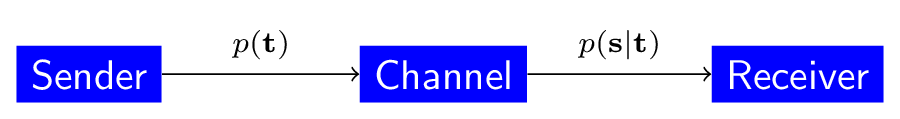

In [145]:
%%tikz
\tikzset{every node/.style={font=\sffamily,white}} 
\node[fill=blue] at (0,0) (a) {Sender}; 
\node[fill=blue] at (3,0) (b) {Channel}; 
\node[fill=blue] at (6,0) (c) {Receiver}; 
\draw[->] (a) -- (b) node [midway,above,font=\scriptsize,black]{$p(\mathbf{t})$}; 
\draw[->] (b) -- (c) node [midway,above,font=\scriptsize,black]{$p(\mathbf{s}|\mathbf{t})$};

* What does $\prob(\source|\target)$ correspond to?
* What does $\prob(\target)$ correspond to?

### Noisy Channel in MT
* $\prob_{\params_s}(\source|\target)$ is called the **translation model**
* $\prob_{\params_t}(\target)$ is the **language model**

MLE for $\prob_\params(\target,\source) = \prob_{\params_t}(\target) \prob_{\params_s}(\source|\target)$ can be calculated in two **independent steps**:
* Estimate $\params_t$ for $\prob_{\params_t}(\target)$
* Estimate $\params_s$ for $\prob_{\params_s}(\source|\target)$

Why useful?

## Impossible Translation Model

$$
\prob^{\text{Impossible}}_\params(\source|\target) = \params_{\source,\target}
$$

Why impossible?

Generally we want models that **factorize** (break up into smaller parts) for dealing with 

* **sparsity**
* **memory limitations**
* **runtime limitations**

How did **language models** do this? 

Look at example for inspiration:

|Token| 1 | 2 | 3 | 4 | 
|-|---|---|---|---|
|**Target**| the | house | is | small |
|**Source**| das | Haus | ist | klein |

$$
\prob_\theta(\source|\target) = \ldots
$$

## Naive Translation Model

$$
\prob_\params^\text{Naive}(\source|\target) = \prod_i^{\length{\source}} \prob_\params(\ssource_i|\starget_i) = \prod_i^{\length{\source}} \param_{\ssource_i,\starget_i}
$$

Why naive?

### Training

Use the **Maximum Likelihood Estimate**:

$$
\params^* = \argmax_\params \sum_{(\target,\source) \in \train} \log \prob_\params(\source|\target)
$$


Amounts to **counting**: 

$$
\param^*_{\ssource,\starget} = \frac{\counts{\train}{s,t}}{\counts{\train}{t}} 
$$


In Python:

In [205]:
from collections import defaultdict 
def learn_naive_model(data):
    norm = defaultdict(float)
    counts = defaultdict(float) 
    for target, source in data:
        for i in range(0, len(target)):
            norm[target[i]] += 1.0
            counts[(source[i],target[i])] += 1.0
    result = {}
    for (source,target),score in counts.items():
        result[(source,target)] = score / norm[target]
    return result
# show defaultdict behaviour

In [147]:
naive_model = learn_naive_model([[('the','house'),('das','Haus')],
                                 [('the','house'),('das','Gebauede')]])
# try other genders or numbers 
util.Table(naive_model.items(), "2em", "20px")

"('Gebauede', 'house')",0.5
"('das', 'the')",1.0
"('Haus', 'house')",0.5


On all data:

In [148]:
util.Table(train, "1.5em", "20px")

"['the', 'house', 'is', 'small']","['das', 'Haus', 'ist', 'klein']"
"['the', 'house', 'is', 'small']","['klein', 'ist', 'das', 'Haus']"
"['a', 'man', 'is', 'tall']","['ein', 'Mann', 'ist', 'groß']"
"['my', 'house', 'is', 'small']","['klein', 'ist', 'mein', 'Haus']"


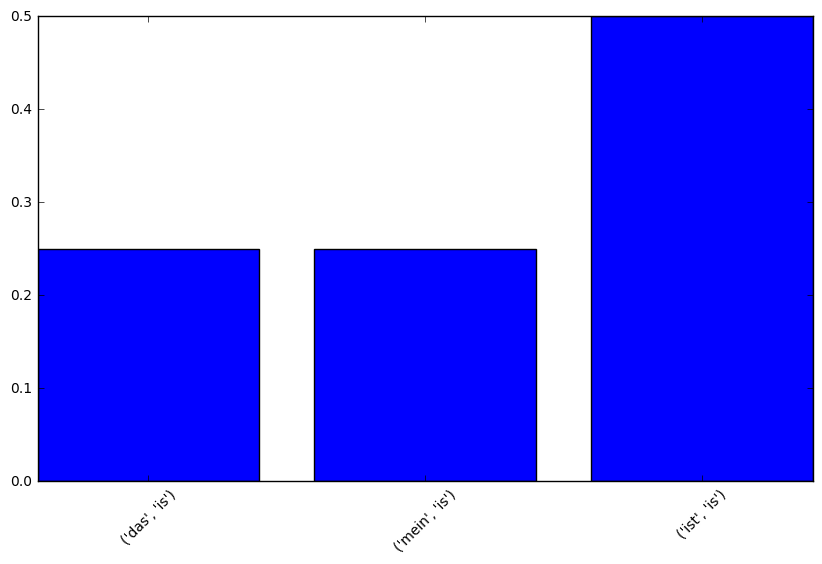

In [149]:
table = learn_naive_model(train)
plot_table_for_target(table, "is")

### Translation / Decoding

Find the highest scoring target $\y$ 

$$
\target^*(\source) = \argmax_\target \prod_i^{\length{\source}} \prob_\params(\ssource_i|\starget_i)
$$


How about **brute-force** (like in our SP example)?

### Local Decoding 

How to find this $\argmax$?

$$
\argmax_{y_1,y_2} f_1(y_1) f_2(y_2) = \ldots
$$


### Local Decoding for the Naive Model

$$
\target^*(\source) = \argmax_\target \prod_i^{\length{\source}} \prob_\params(\ssource_i|\starget_i) \\
= (\argmax_{\starget_1}  \prob_\params(\ssource_1|\starget_1), \ldots, \argmax_{\starget_{\length{\source}}}  \prob_\params(\ssource_{\length{\source}}|\starget_{\length{\source}}))
$$



In Python

In [150]:
def decode(source_sent, model, lm):
    source_to_targets = defaultdict(list)
    for (source,target),prob in model.items():
        source_to_targets[source] += [(target,prob)]
    result = []
    for tok in source_sent:
        candidates = source_to_targets[tok]
        multiplied_with_lm = [(target,prob * lm.probability(target)) for target, prob in candidates]
        target = max(multiplied_with_lm, key=lambda t: t[1])
        result.append(target[0])
    return result

lm = UniformLM(set([target for _, target in table.keys()]))
decode(["ein", "Mann"], table, lm)

['a', 'man']

## Alignments
The Naive Model assumes a sequential **alignment**

In [151]:
word_mt.Alignment("the house is small".split(" "),
                  "das Haus ist klein".split(" "),
                  [(0,0),(1,1),(2,2),(3,3)])

But word order can differ! 

In [152]:
word_mt.Alignment("the house is small".split(" "),
                  "klein ist das Haus".split(" "),
                  [(0,2),(1,3),(2,1),(3,0)])

We formalise alignments like so:

* for each source sentence index \\(i \in [1 \ldots \length{\source}]\\)
    * \\(a_i \in [0 \ldots \length{\target}]\\): index of **aligned target word**
* \\(\align_i\\) can be \\(0\\)
    * Corresponds to imaginary _NULL_ token \\(\starget_0\\)


In [153]:
word_mt.Alignment("NULL the house is small".split(" "),
                  "klein ist das Haus".split(" "),
                  [(1,2),(2,3),(3,1),(4,0)])

$a_1 = $ ??? 

Why the **NULL** Token? 

In [154]:
word_mt.Alignment("NULL 家 わ 小さいい です".split(" "),
                  "The house is small".split(" "),
                  [(0,0),(1,1),(3,3),(4,2)])

Alignments are **hidden** when given a source! 

Need to be 
* modelled
* predicted or marginalised out

## IBM Model 2
Translation and alignment model:

$$
\prob(\source,\aligns|\target)
$$

*Generative story* with parameters $\params = (\alpha, \beta, \epsilon)$

Given target sentence $\target$ with length $l_\starget$:

* Generate a **source sentence length** $l_\ssource$ with uniform probability $\epsilon$
* Generate a **target position** $a_i$ for each source as position $i$ with probability
* Generate the **source word** $\ssource_{i}$ at $a_i$ with probability $\alpha(\ssource_i|\starget_{a_i})$ 

\begin{equation}
  p_\params^\text{IBM2}(\ssource_1 \ldots \ssource_{l_\ssource},\align_1 \ldots \align_{l_\ssource}|\starget_1 \ldots \starget_{l_\starget}) = \epsilon \prod_i^{l_\ssource} \alpha(\ssource_i|\starget_{a_i}) \beta(a_i|i,l_\starget,l_\ssource)
\end{equation}

Example:
$$
p_\params^\text{IBM2}(\text{das, haus},1, 2 | \text{NULL, the, house}) = \ldots
$$

Answer: 
$$
\ldots 
$$

How to use as 
### Translation Model?

When you translate you **don't know alignments**
* and you **don't care**

**Marginalise** them out:

$$
  p_\params^\text{IBM2}(\source|\target) =  \sum_{\aligns}  p_\params^\text{IBM2}(\source,\aligns|\target) 
$$

## Training IBM Model 2

If we had $\train = ((\source_i, \aligns_i, \target_i))_i$ we could optimise

$$
\sum_{(\source, \aligns, \target) \in \train} \log p_\params^\text{IBM2}(\source,\aligns|\target)
$$

But we have **no training alignments** 

Instead use **sentence-aligned** data $\train = ((\source_i, \target_i))_i$ 

and **marginal log-likelihood**


$$
\sum_{(\source, \target) \in \train}  \sum_{\aligns} \log p_\params^\text{IBM2}(\source,\aligns|\target)
$$

**No closed-form** solution

## Expectation Maximisation (EM) Algorithm
maximises a [lower bound of marginal log-likelihood](http://localhost:8888/notebooks/chapters/em.ipynb) 

Figures out (soft) alignments by iterating:

* **E-step**: Infer alignments (or their **expectations**)
    * using current parameters
*  **M-step**: **Maximise** training objective to estimate parameters 
    * using current alignments  

How is this even possible? 

In [155]:
word_mt.Alignment("A B | C A | Q P".split(" "),
                  "X Y | Z X | S T".split(" "),[])

$\a(\text{X}|\text{A})=\ldots \qquad \a(\text{X}|\text{B})=\ldots \qquad \a(\text{T}|\text{P})=\ldots$

$\b(1|1)=\ldots \qquad \b(1|2)=\ldots$


Formalise and implement, but for dataset with `NULL` tokens and 

* consistent but **non-monotonic alignment**

such that EM will 
* first learn about word-to-word correspondences
* and then about distortion

In [157]:
train_model_2_raw = [
  ("NULL the house is small" , "klein ist das Haus"),
  ("NULL a man is tall" , "groß ist ein Mann"),
  ("NULL my house is small" , "klein ist mein Haus"),
  ("NULL the building is big" , "groß ist das Gebäude"),
  ("NULL the building is long" , "lang ist das Gebäude")
]
train_model_2 =  [(t.split(" "), s.split(" ")) for t,s in train_model_2_raw]

### E-Step

Calculate distribution over alignments given source and target 
$$
\pi(\aligns|\source,\target) = p_\params^\text{IBM2}(\aligns|\source,\target)
$$

Distribution **factorizes** for Model 2:
$$
\pi(\aligns|\source,\target) = \prod_i^{l_{\ssource}} \pi(a_i|\source,\target,i) 
$$

with

$$
\pi(a_i|\source,\target,i) = 
  \frac
    {\alpha(\ssource_i|\starget_{a_i}) \beta(a_i|i,l_\starget,l_\ssource)}
    {\sum_j^{l_{\starget}} \alpha(\ssource_i|\starget_j) \beta(j|i,l_\starget,l_\ssource) }
$$

In Python:

In [156]:
def e_step(model, data):
    all_alignments = []
    for target, source in data:
        def score(si, ti):
            return model.alpha[source[si],target[ti]] * model.beta[ti,si, len(target),len(source)]
        result = []
        for si in range(0, len(source)):
            scores = norm_scores([score(si,ti) for ti in range(0, len(target))])
            result.append(scores)
        all_alignments.append(result)
    return all_alignments

Use an **initial model** for first step

In [158]:
source_vocab = set([tok for _,s in train_model_2 for tok in s])
target_vocab = set([tok for t,_ in train_model_2 for tok in t])
max_length = 5

alpha = mt.create_translation_table(source_vocab, target_vocab) #  {'is':'ist'}
beta = mt.create_distortion_table(max_length)

init_model = IBMModel2(alpha,beta)
align_matrices = e_step(init_model, train_model_2)
sent = 0
word_mt.Alignment.from_matrix(align_matrices[sent], train_model_2[sent][1], train_model_2[sent][0])

### M-Step

The M-Step optimizes a *weighted* or *expected* version of log-likelihood using distribution \\(\pi\\) from last E-Step:

$$
  \params^* = \argmax_\params \sum_{(\target,\source) \in \train} \sum_\aligns \pi(\aligns|\target,\source) \log \prob _\params^\text{IBM2}(\source,\aligns|\target)
$$

Because \\(\pi\\) factorizes we have a closed-form solution:

$$
  \alpha(\ssource|\starget) = \frac
    {\sum_{(\target,\source)}\sum_i^{l_\source} \sum_j^{l_\target} \pi(j|i) \delta(\ssource,\ssource_i) \delta(\starget,\starget_j) }
    {\sum_{(\target,\source)} \sum_j^{l_\target} \delta(\starget,\starget_j) }
$$

* \\(\delta(x,y)\\) is 1 if \\(x=y\\) and 0 otherwise

Implement M-Step, estimating parameters \\(\params\\) from (soft) alignments \\(\aligns\\)

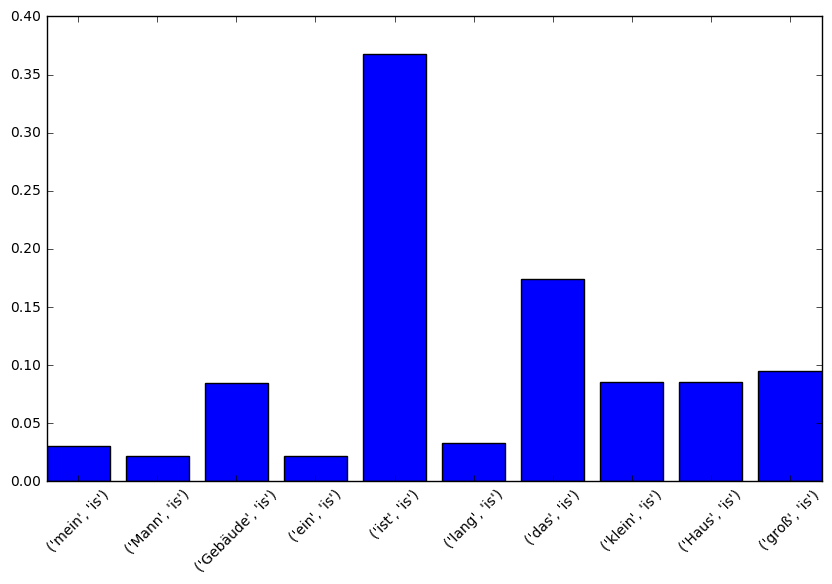

In [169]:
theta1 = m_step(align_matrices, train_model_2)    
plot_table_for_target(theta1.alpha, "is") # try house!

In [165]:
align_matrices = e_step(theta1, train_model_2)
sent = 2
word_mt.Alignment.from_matrix(align_matrices[sent], train_model_2[sent][1], train_model_2[sent][0])

### Initialisation
Good initialisation is **crucial for EM**

### Baby Steps
Initialise with the parameters of a simpler model with **fixed distortion** table:

$$
  \beta(a_i|i,l_\starget,l_\ssource) = \frac{1}{l_\starget + 1}
$$

This is **IBM Model 2**!

Train IBM Model 1 and see if it **converges**

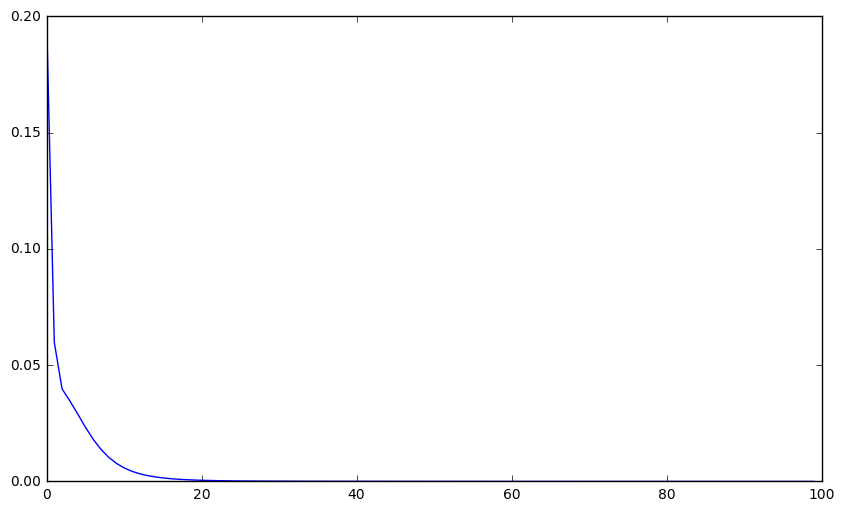

In [170]:
ibm1_iterations = em_model1(init_model, train_model_2, 100)
plt.plot(range(0,len(ibm1_iterations)), [change for _, _, change in ibm1_iterations])

Translation Table?

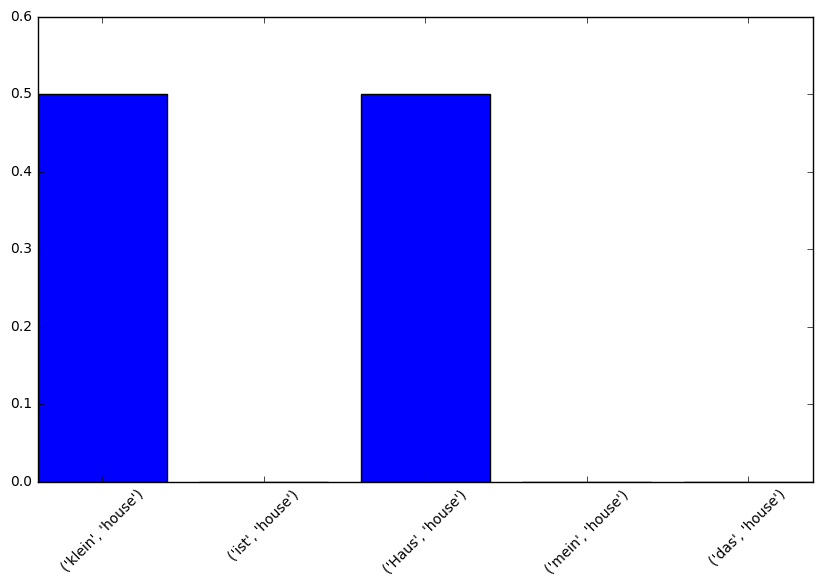

In [171]:
plot_table_for_target(ibm1_iterations[-1][1].alpha, "house")

Alignments?

In [179]:
sent = 4
word_mt.Alignment.from_matrix(ibm1_iterations[-1][0][sent],train_model_2[sent][1], train_model_2[sent][0])

Now learn **distortion table** in Model 2

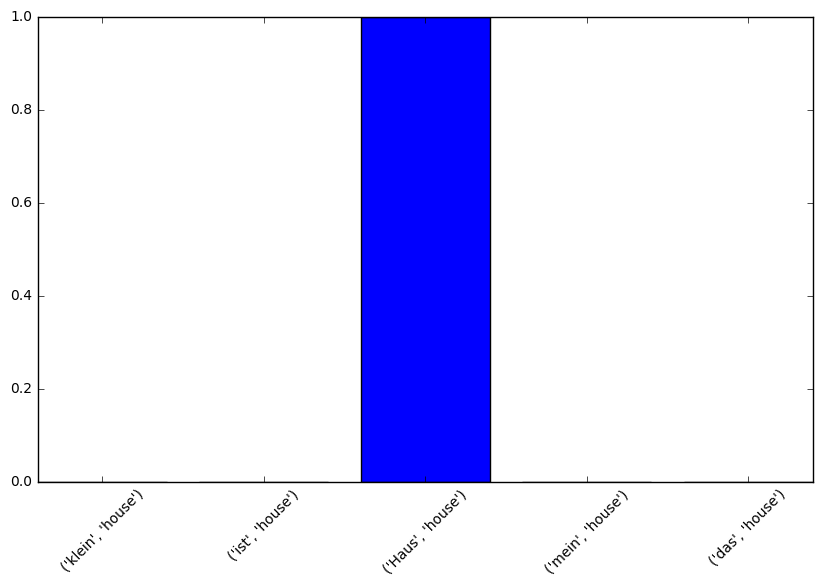

In [180]:
ibm1 = ibm1_iterations[-1][1] # model 1 of last iteration 
ibm2_iterations = em_model2(ibm1, train_model_2, 100)
ibm2 = ibm2_iterations[-1][1] # model 2 of last iteration
plot_table_for_target(ibm2.alpha, "house")

Alignments? 

In [185]:
sent = 0
word_mt.Alignment.from_matrix(ibm2_iterations[-1][0][sent],train_model_2[sent][1], train_model_2[sent][0])
# replace with ibm1_iterations

Distortion table?

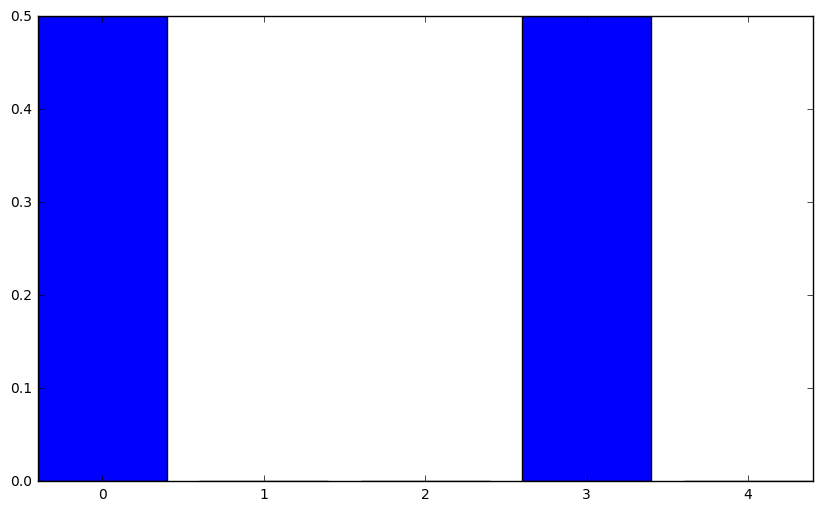

In [195]:
def distort(si):
    return [ibm2.beta[ti,si,5,4] for ti in range(0,5)]
util.plot_bar_graph(distort(1),range(0,5)) # change source index != 0

## Decoding with Model 2

Solve
$$
\argmax_{\target,\aligns} p_\params^\text{IBM2}(\source,\aligns|\target) \prob^\text{LM}(\target)
$$

Do you care about the alignments $\aligns$? 

Choices:

* Simple **approximate** method
* Complex **exact** method

Both presentend in [these slides](https://www.dropbox.com/s/p495n19h5rtk3uf/IBM-decoding.pdf?dl=0)

Choices:

* Simple **approximate** method
* Complex **exact** method

Both presentend in [these slides](https://www.dropbox.com/s/p495n19h5rtk3uf/IBM-decoding.pdf?dl=0)

### Beam Based Decoder
Maintains a list of top-$k$ hypotheses in a **beam**

In [203]:
lm_train = [tok for t,_ in train_model_2 for tok in t]
lm = UniformLM({w for w in target_vocab if w != 'NULL'})
# lm = LaplaceLM(NGramLM(lm_train, 3),0.1)
hist2 = decode_model_2(ibm2, lm, source, 5)
render_history(hist2[:1])

NULL,groß ist ein Mann,4,0.0


## Summary 

* MT is an instance structured prediction recipe
* The noisy channel is one modeling framework
* word-based MT is foundation and blue print for more complex models
* Training with EM
* NLP Tricks: 
    * introducing latent alignment variables to simplify problem
    * decoding with Beams

## Background Material
* [Lecture notes on IBM Model 1 and 2](http://www.cs.columbia.edu/~mcollins/courses/nlp2011/notes/ibm12.pdf) of Mike Collins.  
* Jurafsky & Martin, Speech and Language Processing: 
    * Chapter 26, Machine Translation.
    * Chapter 6, EM Algorithm
* Brown et al., [The Mathematics of Statistical Machine Translation: Parameter Estimation](http://www.aclweb.org/anthology/J93-2003)